In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchinfo
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, BaselineNN, HistEqualizationTransform,class6_Dataset, ResnetTransfer
import torch
from torch import nn
import torchvision
import torcheval
from torcheval.metrics import BinaryAccuracy
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
35477  MURA-v1.1\train\XR_WRIST\patient08642\study1_n...  train     XR_WRIST   
16700  MURA-v1.1\train\XR_HAND\patient10928\study1_ne...  train      XR_HAND   
15357  MURA-v1.1\train\XR_HAND\patient10444\study1_ne...  train      XR_HAND   
269    MURA-v1.1\train\XR_ELBOW\patient01684\study1_n...  train     XR_ELBOW   
5578   MURA-v1.1\train\XR_FINGER\patient03261\study1_...  train    XR_FINGER   
16453  MURA-v1.1\train\XR_HAND\patient10838\study1_ne...  train      XR_HAND   
33410  MURA-v1.1\train\XR_WRIST\patient07962\study1_n...  train     XR_WRIST   
25993  MURA-v1.1\train\XR_SHOULDER\patient02354\study...  train  XR_SHOULDER   
10986  MURA-v1.1\train\XR_FOREARM\patient09294\study1...  train   XR_FOREARM   
18822  MURA-v1.1\train\XR_SHOULDER\patient00048\study...  train  XR_SHOULDER   

            Patient       FolderName   Study     Label  
35477  patient08642  study1_negative  study1  negative  
16700  patient10928  study1_negative  study1  negative  
15357  patient10444  study1_negative  study1  negative  
269    patient01684  study1_negative  study1  negative  
5578   patient03261  study1_positive  study1  positive  
16453  patient10838  study1_negative  study1  negative  
33410  patient07962  study1_negative  study1  negative  
25993  patient02354  study1_negative  study1  negative  
10986  patient09294  study1_positive  study1  positive  
18822  patient00048  study1_positive  study1  positive

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


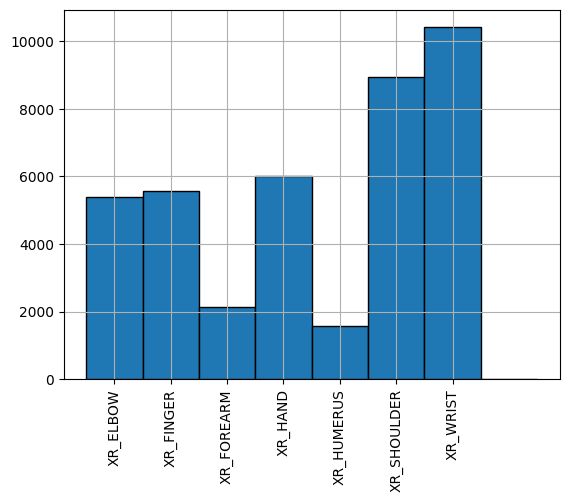

In [5]:

everythingScans_df['Bone'].hist(bins=range(0,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [7]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05818\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\valid\XR_FINGER\patient11213\study2_...  valid    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09303\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient02607\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient02460\study1...  train   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient02204\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08342\study1_n...  train     XR_WRIST   
7   MURA-v1.1\valid\XR_ELBOW\patient11827\study1_p...  valid     XR_ELBOW   
8   MURA-v1.1\valid\XR_FINGER\patient11920\study1_...  valid    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient09203\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient09755\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02731\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient00714\study...  train  XR_SHOULDER   
13  MURA-v1.1\train\XR_WRIST\patient07429\study1_p...  train     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05818  study1_negative  study1  negative  
1   patient11213  study2_negative  study2  negative  
2   patient09303  study1_negative  study1  negative  
3   patient02607  study1_negative  study1  negative  
4   patient02460  study1_negative  study1  negative  
5   patient02204  study1_negative  study1  negative  
6   patient08342  study1_negative  study1  negative  
7   patient11827  study1_positive  study1  positive  
8   patient11920  study1_positive  study1  positive  
9   patient09203  study1_positive  study1  positive  
10  patient09755  study1_positive  study1  positive  
11  patient02731  study1_positive  study1  positive  
12  patient00714  study1_positive  study1  positive  
13  patient07429  study1_positive  study1  positive

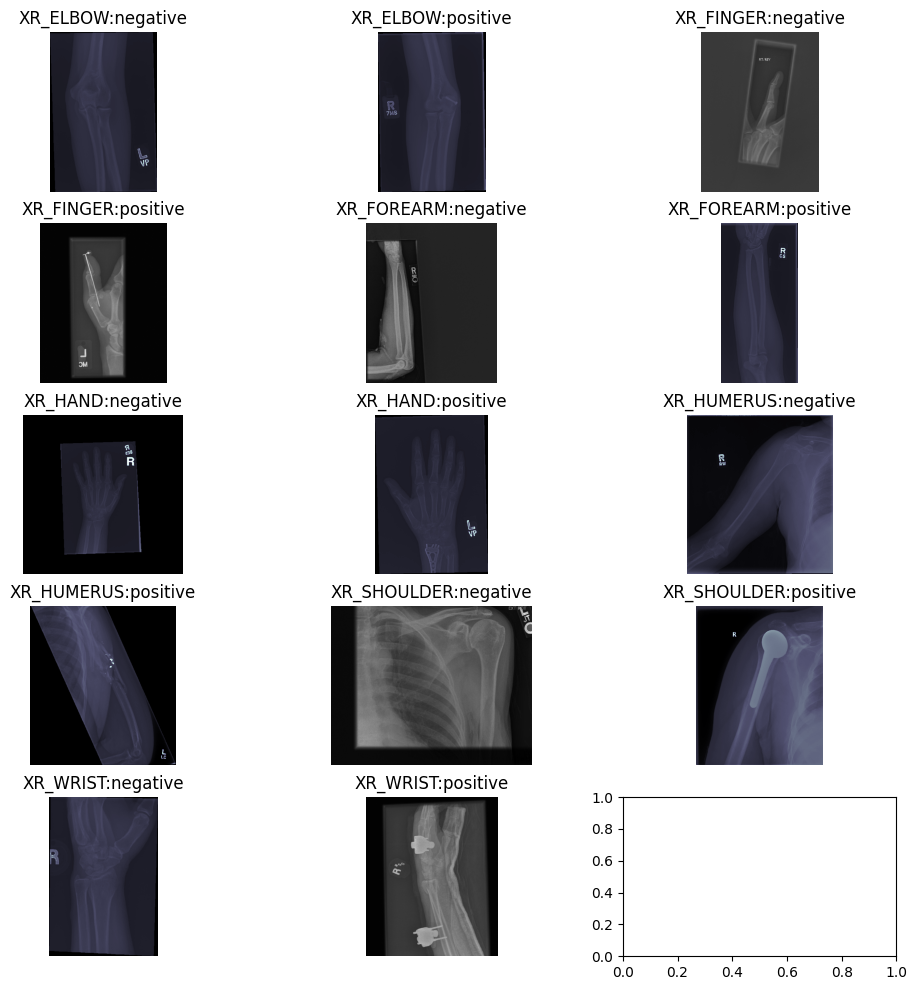

In [11]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(5, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus
humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
17999  MURA-v1.1\train\XR_HUMERUS\patient02904\study1...  train  XR_HUMERUS   
17780  MURA-v1.1\train\XR_HUMERUS\patient02807\study1...  train  XR_HUMERUS   
17479  MURA-v1.1\train\XR_HUMERUS\patient01780\study1...  train  XR_HUMERUS   
17457  MURA-v1.1\train\XR_HUMERUS\patient01245\study1...  train  XR_HUMERUS   
17957  MURA-v1.1\train\XR_HUMERUS\patient02886\study1...  train  XR_HUMERUS   
17483  MURA-v1.1\train\XR_HUMERUS\patient01811\study2...  train  XR_HUMERUS   
17507  MURA-v1.1\train\XR_HUMERUS\patient02339\study1...  train  XR_HUMERUS   
17851  MURA-v1.1\train\XR_HUMERUS\patient02840\study1...  train  XR_HUMERUS   
17767  MURA-v1.1\train\XR_HUMERUS\patient02802\study1...  train  XR_HUMERUS   
17736  MURA-v1.1\train\XR_HUMERUS\patient02787\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
17999  patient02904  study1_positive  study1  positive  
17780  patient02807  study1_positive  study1  positive  
17479  patient01780  study1_negative  study1  negative  
17457  patient01245  study1_negative  study1  negative  
17957  patient02886  study1_positive  study1  positive  
17483  patient01811  study2_negative  study2  negative  
17507  patient02339  study1_positive  study1  positive  
17851  patient02840  study1_positive  study1  positive  
17767  patient02802  study1_positive  study1  positive  
17736  patient02787  study1_positive  study1  positive

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


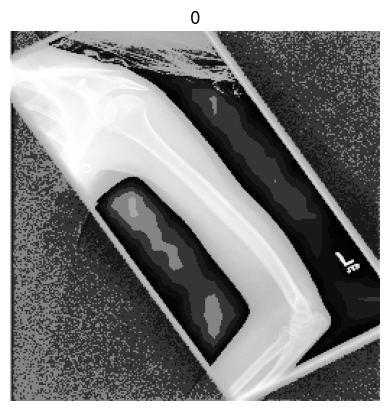

In [9]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    HistEqualizationTransform(),
    
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(2)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [10]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    #HistEqualizationTransform(),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002D491432D10>, <torch.utils.data.dataloader.DataLoader object at 0x000002D491459240>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [41]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5, pretrained=False):

    #put in training mode
    model.train()
    #reset model parameters
    if not pretrained:
        model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        loss_per_epoch=0


        print(f"Epoch {epoch+1}/{num_epochs}")

        #batch computations
        for i, (inputs, labels) in enumerate(dataloader):
            print("batch number",i)
            if pretrained:
                pass
            else:
                inputs=inputs.view(inputs.shape[0],-1)
            #print(inputs.shape,inputs.dtype)
            if pretrained:
                outputs=model(inputs).squeeze()
            else:
                outputs=model(inputs)
            print("predictions probabilities are: ",outputs[:10])
            outputs.type_as(labels)
            #labels=labels.type_as(outputs)
            print("real labels: ",labels[:10])
            #loss returns mean loss per batch unless specified otherwise

            batch_loss=loss_fn(outputs,labels)

            #add the batch_loss to epoch loss
            loss_per_epoch+=batch_loss.item()

            optimizer.zero_grad()
            #update parameters
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            #print(i, loss.item())
            # if i%8==0:
            #     print(f"Loss at iteration {i} is {round((loss_per_epoch/8),4)}")
            #     #loss_istory has acumulated the mean loss of 8 batches so we divide by 4 to get 
            #     # avg loss per batch
            #     loss_history.append(round((loss_per_epoch/8),4))
            #     loss_per_epoch=0
            if i % 9 == 0:
                print(f"Cumuative Loss at batch {i} is {round((loss_per_epoch/9),4)}")


        print(f"Loss at epoch {epoch+1} is {round((loss_per_epoch/len(dataloader)),4)}")
        loss_history.append(round((loss_per_epoch/len(dataloader)),4))
    return loss_history
    
@torch.no_grad()    
def evaluate(model, dataloader, loss_fn, accuracy_fn, pretrained=False):
    model.eval()

    loss_history=[]
    eval_loss=0
    eval_acc=0
    
    for i, (inputs, labels) in enumerate(dataloader):
        print(inputs.dtype,labels.dtype)
        # if pretrained:
        #     pass
        # else:
        #     inputs=inputs.view(inputs.shape[0],-1)
        # if pretrained:
        #     outputs=model(inputs).squeeze()
        # else:
        #     outputs=model(inputs)
        outputs=model(inputs)
        #labels=labels.type_as(outputs)
        outputs.type_as(labels)
        loss=loss_fn(outputs,labels)
        eval_loss+=loss.item()
        accuracy_fn.update(outputs,labels)
        print("accuracy is: ",accuracy_fn.compute())
        #Binary accuracy returns the accuracy per batch
        # eg if batch size is 32 and 25 are correct, it returns tensor(25/32)
        eval_acc+=accuracy_fn.compute()

        loss_history.append(round(loss.item(),4))
    eval_loss=eval_loss/len(dataloader)
    eval_acc=eval_acc/len(dataloader)
    print(f"\n Test loss: {eval_loss:.5f}, Test acc: {eval_acc*100:.2f}%\n")
    return loss_history

In [ ]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
#BCELoss(sigmoid_output,true_labels)
loss_fn=torch.nn.BCELoss(reduction='mean')
model=BaselineNN(input_size=input_size, hidden_size=128, output_size=1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
accuracy_fn=BinaryAccuracy(threshold=0.5)
print(type(accuracy_fn))
train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=2)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn=accuracy_fn)

plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')


In [12]:
from torchvision.models import ResNet18_Weights

transformation_dict= {

    'train':torchvision.transforms.Compose([]),
    
    'train_resnet': torchvision.transforms.Compose(
        [ResNet18_Weights.DEFAULT.transforms(),
        torchvision.transforms.RandomAutocontrast(p=0.5),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
    ]
    )


}

In [42]:
everything_copy=everythingScans_df.copy()
everything_1000_train=everything_copy.loc[everything_copy['Split']=='train']
ev_1000_train_df=everything_1000_train.groupby(['Bone', 'Label']).apply(lambda x: x.sample(500)).reset_index(drop = True)
# ev_1000_train_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
# plt.xticks(rotation=90)
# plt.show()
# ev_1000_train_df['Label'].hist()
train_dataloader=DataLoader(class6_Dataset(ev_1000_train_df,transform=transformation_dict['train_resnet']),batch_size=128,shuffle=True)
everything_100_valid=everything_copy.loc[everything_copy['Split']=='valid']
ev_100_valid_df=everything_100_valid.groupby(['Bone', 'Label']).apply(lambda x: x.sample(100)).reset_index(drop = True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
valid_dataloader=DataLoader(class6_Dataset(ev_100_valid_df,transform=None),batch_size=32,shuffle=True)
valid_features_batch, valid_labels_batch = next(iter(valid_dataloader))


In [36]:
model.eval()
outputs=model(valid_features_batch)
loss=loss_fn(outputs,valid_labels_batch)
pprint(loss.item())

1.5695405006408691


In [ ]:
from torchmetrics import Accuracy
loss_fn=torch.nn.CrossEntropyLoss(reduction='mean')
model=ResnetTransfer(train_resnet=True)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
accuracy_fn=Accuracy(task='multiclass', num_classes=7,threshold=0.5)
train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=1, pretrained=True)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

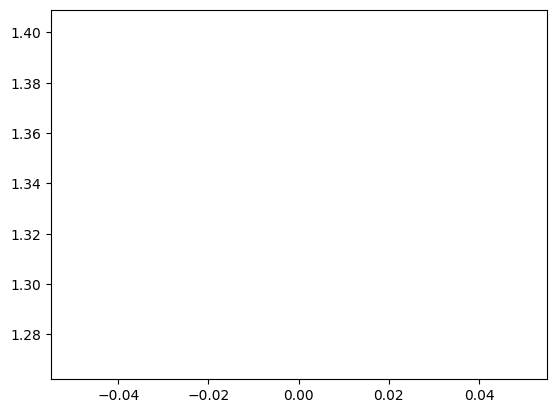

In [46]:

plt.plot(train_loss_history, label='train')

#plt.plot(valid_loss_history, label='valid')

In [ ]:
#freeze all layers
#use weights and default so as not to get warnings
#use pretrained weights
weights=torchvision.models.ResNet18_Weights.DEFAULT
resnet18 = torchvision.models.resnet18(weights=weights)
for param in resnet18.parameters():
    param.requires_grad=False

weights.transforms()
in_features=resnet18.fc.in_features
#output only 1 value for binary classification
#the output is not passed through sigmoid
resnet18.fc=torch.nn.Linear(in_features,1)
#torchinfo.summary(resnet18, input_size=(32, 3, 256, 256),col_names=["input_size", "output_size", "num_params", "trainable"], verbose=2)
#only optimize the parameters of the last layer
optimizer=torch.optim.Adam(resnet18.fc.parameters(),lr=0.001)
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCEWithLogitsLoss(reduction='mean')
accuracy_fn=torcheval.metrics.BinaryAccuracy(threshold=0.5)
model=resnet18
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=1, pretrained=True)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

